

---

#<center> DLTS TP3: Reconnaissance de signaux de communication par apprentissage profond

###<center> *Binôme : Imane SI SALAH, Nour BOUAYED*
---



## *Problématique*

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié.

L'émetteur peut provenir de 6 catégories différentes.
Les paramètres différenciant les différentes catégories sont
- le type de modulation
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données
- le débit de la transmission

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0.


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation
électromagnétiques comme :
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données).
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

**Les objectifs de ce TP**:
1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html.
3. Qualifier les performances de notre réseau de neurones sur l'ensemble de test via:
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)



## Imports

In [ ]:
!pip install torchmetrics

In [ ]:
import numpy as np
import torch
import h5py # pour gérer les formats de données utilisés ici
import matplotlib.pyplot as plt
import torchmetrics
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn


In [ ]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ROOT_PATH='/content/drive/MyDrive/dlts3/'

In [ ]:
SAMPLES_PATH = ROOT_PATH + 'samples.hdf5'
TRAIN_PATH = ROOT_PATH + 'train.hdf5'
VAL_PATH = ROOT_PATH + 'validation.hdf5'
TEST_PATH = ROOT_PATH + 'test.hdf5'

## Chargement des données en numpy et exploration

In [ ]:
samples = h5py.File(SAMPLES_PATH , 'r')

signals = np.array(samples['signaux'])
snr =  np.array(samples['snr'])
labels_id = np.array(samples['labels'])

# samples.close()

In [ ]:
#Pour récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

In [ ]:
labels_dict=get_labels(samples)
label_names = np.array(get_labels(samples).values())
print(label_names)
print(samples.keys())
samples.close()

dict_values(['N-PSK8', 'N-QAM16', 'N-QPSK', 'W-PSK8-V1', 'W-PSK8-V2', 'W-QAM16'])
<KeysViewHDF5 ['label_name', 'labels', 'signaux', 'snr']>


In [ ]:
labels_dict

{1: 'N-PSK8',
 0: 'N-QAM16',
 2: 'N-QPSK',
 4: 'W-PSK8-V1',
 5: 'W-PSK8-V2',
 3: 'W-QAM16'}

  Les valeurs prises par ``label_name`` sont les suivantes :

  ['N-PSK8', 'N-QAM16', 'N-QPSK', 'W-PSK8-V1', 'W-PSK8-V2', 'W-QAM16']

  Elles correspondent à certains standards de modulation utilisés par les systèmes de télécommunication. En particulier, il s'agit de variantes de deux types de modulation :
  - Phase shift keying (PSK)
  - Quadrature amplitude modulation (QAM)

Notre problématique est donc une tâche de Classification Automatique du Type de Modulation (**Automatic Modulation Classification (ACM)**).



In [ ]:
#Train
train = h5py.File(TRAIN_PATH , 'r')

train_signals = np.array(train['signaux'])
train_snr =  np.array(train['snr'])
train_labels_id = np.array(train['labels'])

train.close()

#Valid
val = h5py.File(VAL_PATH , 'r')

val_signals = np.array(val['signaux'])
val_snr =  np.array(val['snr'])
val_labels_id = np.array(val['labels'])

val.close()

#Test
test = h5py.File(TEST_PATH , 'r')

test_signals = np.array(test['signaux'])
test_snr =  np.array(test['snr'])
test_labels_id = np.array(test['labels'])

test.close()

Train signals shape: (30000, 2048, 2)
Validation signals shape: (10000, 2048, 2)
Test signals shape: (10000, 2048, 2)


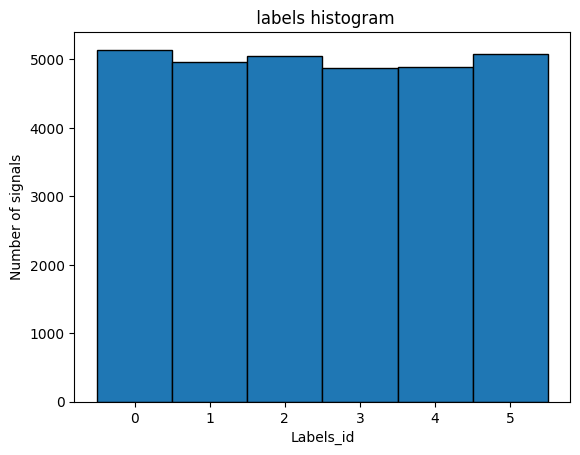

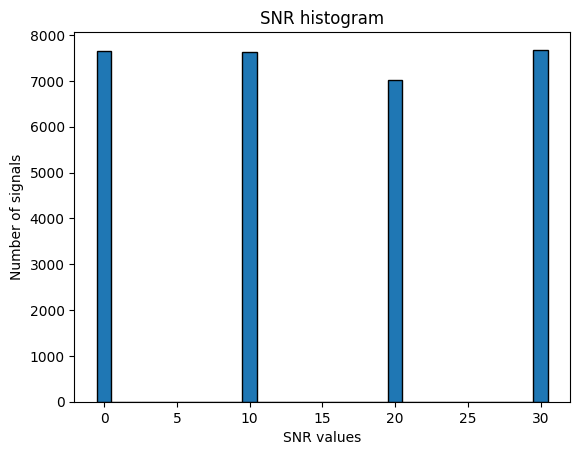

In [ ]:
# size of data
print(f'Train signals shape: {train_signals.shape}')
print(f'Validation signals shape: {val_signals.shape}')
print(f'Test signals shape: {test_signals.shape}')


# classes
plt.figure()
plt.hist(train_labels_id, bins=np.arange(min(train_labels_id)-0.5, max(train_labels_id)+1.5, 1),edgecolor='black')
plt.xlabel('Labels_id')
plt.ylabel('Number of signals')
plt.title(" labels histogram")
plt.show()

#SNR
plt.figure()
plt.hist(train_snr, bins=np.arange(min(train_snr)-0.5, max(train_snr)+1.5, 1),edgecolor='black')
plt.xlabel('SNR values')
plt.ylabel('Number of signals')
plt.title("SNR histogram")
plt.show()

Aucun souci de déséquilibre entre les classes! Classe!

### Constellation Diagrams

In [ ]:
def group_signals_bylabel(signals, labels):
    grouped_signals={}
    # Iterate over each signal and its corresponding attribute (label or snr)
    for signal, label in zip(signals, labels):
        if label not in grouped_signals.keys():
            grouped_signals[label]=[signal]
        else:
            grouped_signals[label].append(signal)
    return grouped_signals

In [ ]:
def plot_constellation(signal):
    plt.scatter(signal[:, 0], signal[ :, 1], alpha=0.5)
    plt.xlabel("I Component")
    plt.ylabel("Q Component")
    plt.grid(True)
    plt.axis("equal")

In [ ]:
signals_bylabel=group_signals_bylabel(train_signals, train_labels_id)

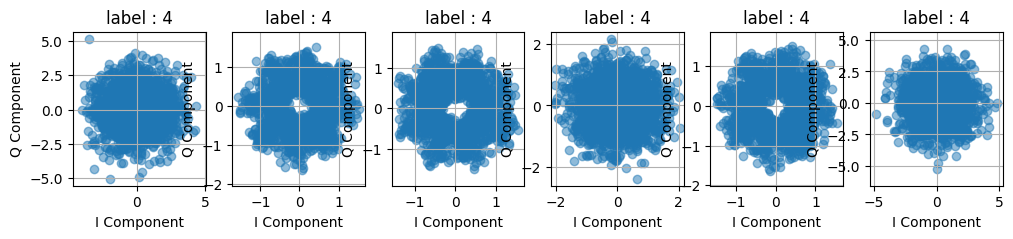

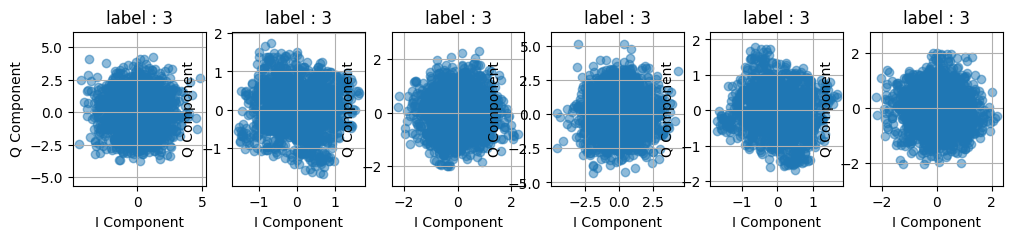

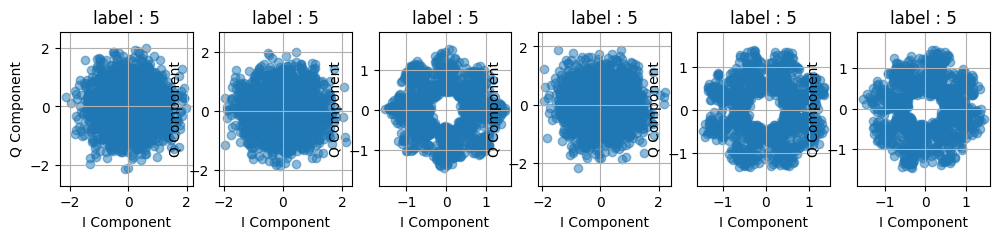

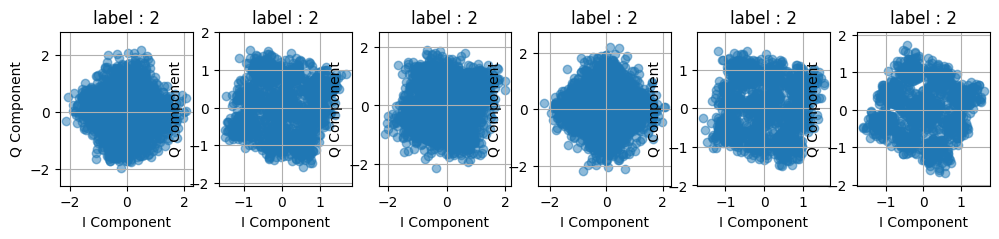

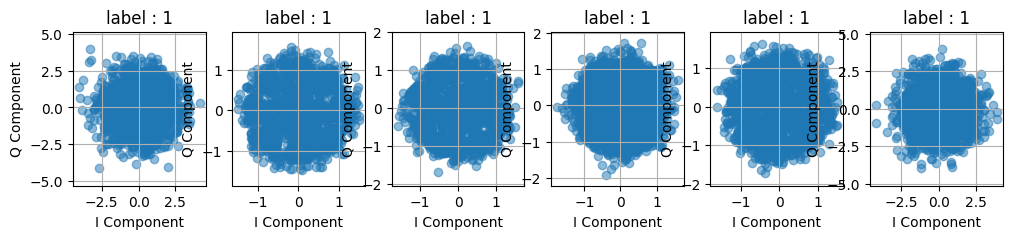

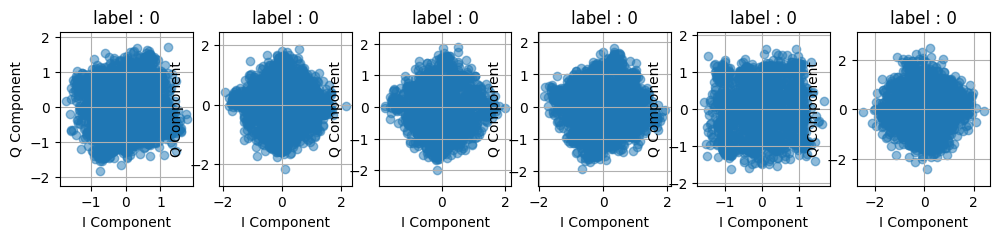

In [ ]:
#Plotting constellation diagrams of some sample signals for each label
for label, group in signals_bylabel.items():
    plt.figure(figsize=(12,2))

    for i,signal in enumerate(group):
        if i>5:
          break
        plt.subplot(1,6,i+1)
        plot_constellation(signal)
        plt.title(f'label : {label}')
    plt.show()

In [ ]:
signals[0].shape

(2048, 2)

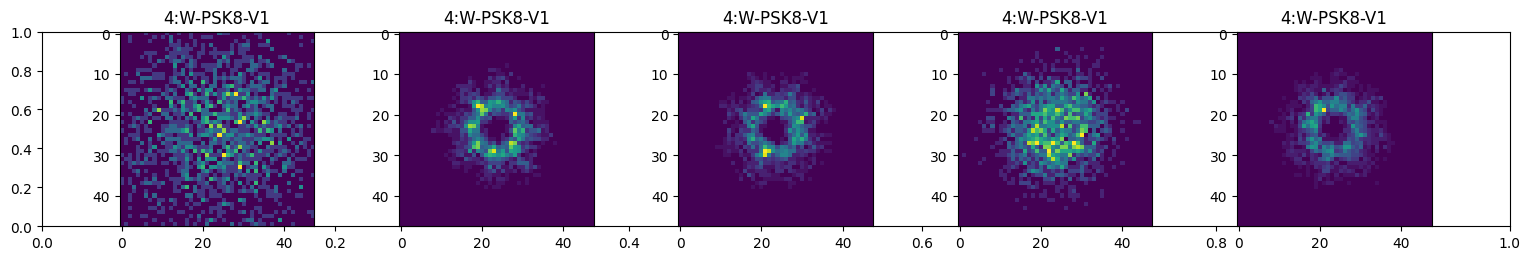

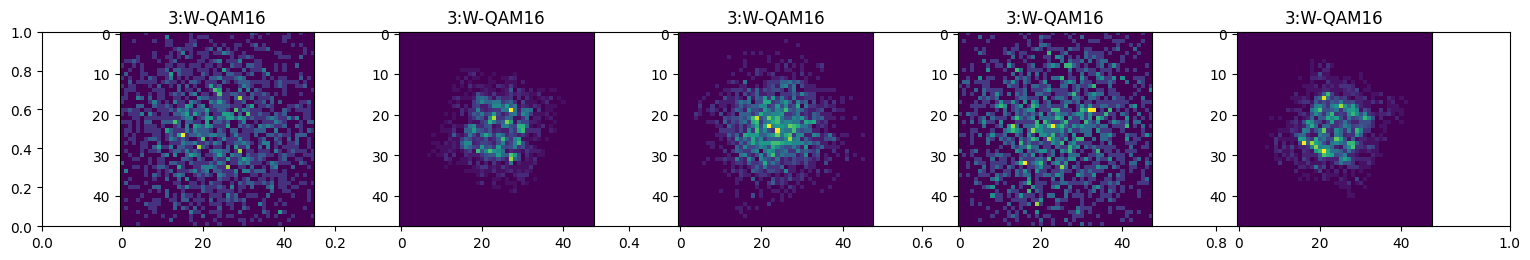

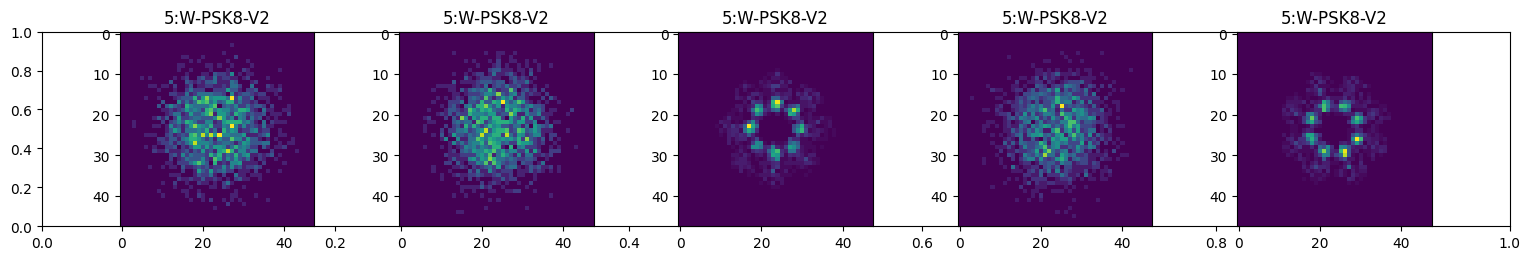

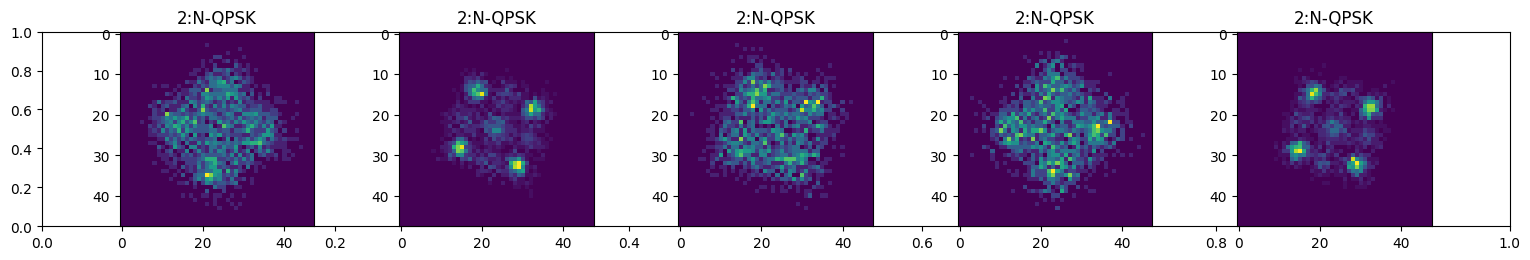

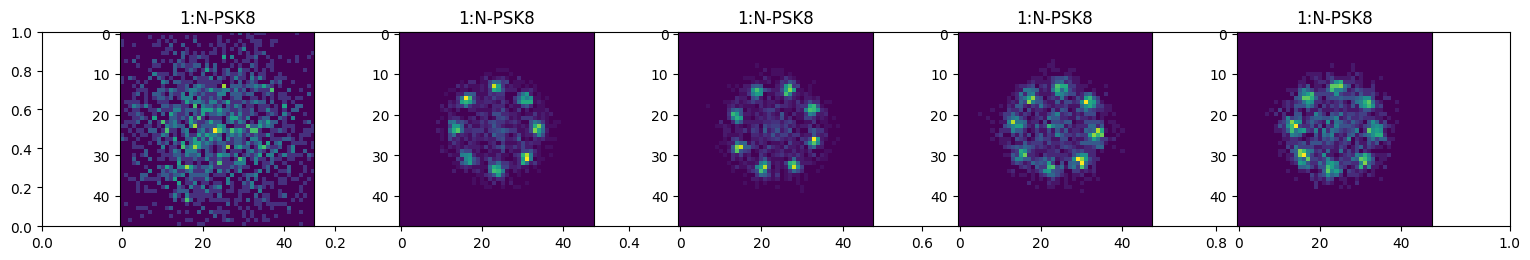

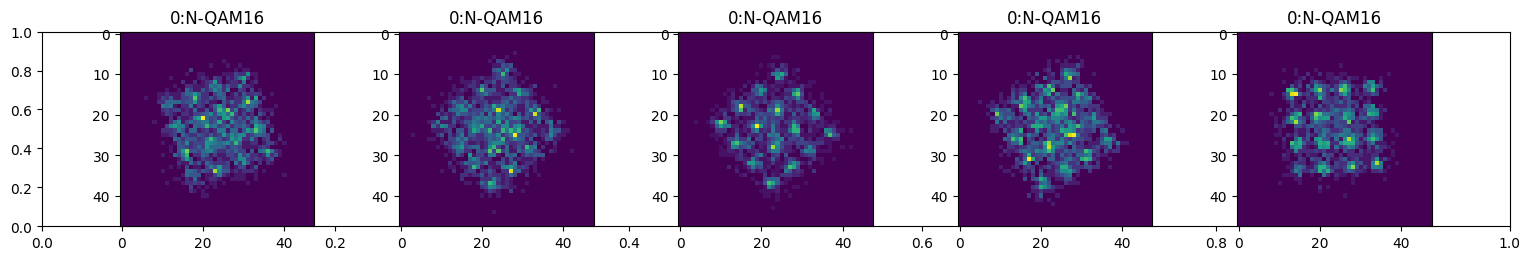

In [ ]:
nbins = 48

for label, group in signals_bylabel.items():
    fig, ax = plt.subplots(figsize=(15,3))
    for i,signal in enumerate(group[:5]):
        ax = fig.add_subplot(1,5,i+1)
        counts, xedges, yedges = np.histogram2d(signal[:,0], signal[:,1], bins=nbins,range = [[-2.5, 2.5], [-2.5, 2.5]])
        ax.imshow(counts)
        ax.set_title(f'{label}:{labels_dict[label]}')
        plt.tight_layout()
    plt.show()

QAM16 est clairement reconnaissable par exemple

On enregistre ces images dans des fichier ``h5py`` afin d'essayer d'entrainer un modèle de computer vision dessus

In [ ]:
#function to apply colormap to array and return the array in colour form
def arr2img(arr, chnum):
  norm = plt.Normalize(vmin=arr.min(), vmax=arr.max())
  if chnum == 1:
      cmap = plt.cm.gray
      image4d = cmap(norm(arr)) #RGBA
      img = image4d[:,:,0] #All RGBA channels identical

  elif chnum == 3:
      cmap = plt.cm.hot #or can choose any other colormap
      image4d = cmap(norm(arr)) #RGBA
      img = image4d[:,:,:3] #ignore A channel

  return img


nbins = 48
ch = 3

constel_train = {'img_signals':[],'snr':[],'labels':[]}
constel_val = {'img_signals':[],'snr':[],'labels':[]}
constel_test = {'img_signals':[],'snr':[],'labels':[]}

#train_constellations
constel_train_file = ROOT_PATH + 'train_constellations.hdf5'
for i, samp in enumerate(train_signals):
    counts, xedges, yedges = np.histogram2d(samp[:,0], samp[:,1], bins=nbins,range = [[-2.5, 2.5], [-2.5, 2.5]])
    img = arr2img(counts, ch)
    constel_train['img_signals'].append(img)
    constel_train['snr'].append(train_snr[i])
    constel_train['labels'].append(train_labels_id[i])
f = h5py.File(constel_train_file, "w")
f.create_dataset('img_signals', data=constel_train['img_signals'])
f.create_dataset('snr', data=constel_train['snr'])
f.create_dataset('labels', data=constel_train['labels'])
f.close()

#val_constellations
constel_val_file = ROOT_PATH + 'val_constellations.hdf5'
for i, samp in enumerate(val_signals):
    counts, xedges, yedges = np.histogram2d(samp[:,0], samp[:,1], bins=nbins,range = [[-2.5, 2.5], [-2.5, 2.5]])
    img = arr2img(counts, ch)
    constel_val['img_signals'].append(img)
    constel_val['snr'].append(val_snr[i])
    constel_val['labels'].append(val_labels_id[i])
f = h5py.File(constel_val_file, "w")
f.create_dataset('img_signals', data=constel_val['img_signals'])
f.create_dataset('snr', data=constel_val['snr'])
f.create_dataset('labels', data=constel_val['labels'])
f.close()


#test_constellations
constel_test_file = ROOT_PATH + 'test_constellations.hdf5'
for i, samp in enumerate(test_signals):
    counts, xedges, yedges = np.histogram2d(samp[:,0], samp[:,1], bins=nbins,range = [[-2.5, 2.5], [-2.5, 2.5]])
    img = arr2img(counts, ch)
    constel_test['img_signals'].append(img)
    constel_test['snr'].append(test_snr[i])
    constel_test['labels'].append(test_labels_id[i])
f = h5py.File(constel_test_file, "w")
f.create_dataset('img_signals', data=constel_test['img_signals'])
f.create_dataset('snr', data=constel_test['snr'])
f.create_dataset('labels', data=constel_test['labels'])
f.close()

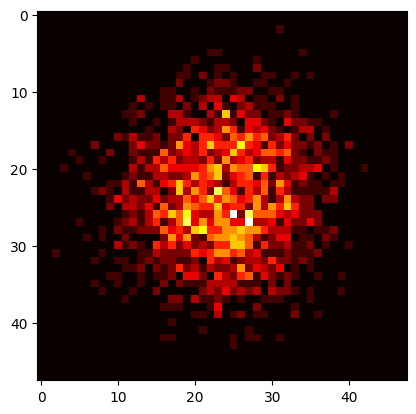

In [ ]:
TRAIN_IMG_PATH = ROOT_PATH + 'train_constellations.hdf5'
train_img = h5py.File(TRAIN_IMG_PATH , 'r')

train_img_signals = np.array(train_img['img_signals'])
train_img_snr =  np.array(train_img['snr'])
train_img_labels_id = np.array(train_img['labels'])

train_img.close()
plt.imshow(train_img_signals[300])

In [ ]:
del train_img_signals

In [ ]:
# del train_img_snr
del train_img_labels_id

## Chargement des données en Pytorch

Le transfert des données de numpy à PyTorch passe par deux objets :

- un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
- un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones

In [ ]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, path_to_data):
    self.path= path_to_data
    self.data=None

  def __getitem__(self, i):
    if self.data==None:
      self.data= h5py.File(self.path, 'r')
    signal= torch.from_numpy(np.array(self.data["signaux"][i])).permute((1,0)) #(T,C) --> (C,T)
    label= torch.from_numpy(np.array(self.data["labels"][i]))
    return (signal, label)

  def __len__(self):
    with h5py.File(self.path, 'r') as f:
      return np.array(f["signaux"]).shape[0]

  def close(self):
      if self.data is not None:
        self.data.close()
        self.data= None

On teste l'objet MyDataset() que l'on vient de créer

In [ ]:
samples_dataset= MyDataset(SAMPLES_PATH)
for sig , l in samples_dataset:
    print(np.array(sig).shape)
    break

(2, 2048)


In [ ]:
from torch.utils.data import DataLoader
b_size=32
samples_loader = DataLoader(samples_dataset, batch_size=b_size,shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
for sig , l in samples_loader:
    print(np.array(sig).shape)
    print(l.shape)

(32, 2, 2048)
torch.Size([32])
(32, 2, 2048)
torch.Size([32])
(32, 2, 2048)
torch.Size([32])
(32, 2, 2048)
torch.Size([32])
(32, 2, 2048)
torch.Size([32])
(32, 2, 2048)
torch.Size([32])
(8, 2, 2048)
torch.Size([8])


## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

On définit un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier).

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que l'on mettra en place par la suite.

In [ ]:
class MyDumbModel(nn.Module):
    '''
        [B,C,T] -->MyDumbModel--> [B,N]
        input_dim : T
        n_classes : N
    '''
    def __init__(self, input_dim=2048, n_classes=6):
        super(MyDumbModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=n_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, input):
        input = torch.norm(input, dim=1) #(B,C,T) -> (B,T) (autrement dit, on prend le module de chaque point complexe du signal, au lieu de prendre les deux coordonnées Re et Im)
        prediction=self.classifier(input) #(B,6)
        return prediction

In [ ]:
#On vérifie que le modèle fonctionne bien (consistence des dimensions d'entrée/sortie)
print(f'input :{sig.shape}')
model=MyDumbModel(2048, 6)
print(f'output :{(model(sig)).shape}')

input :torch.Size([8, 2, 2048])
output :torch.Size([8, 6])


## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à
- charger les données
- les batcher
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires

In [ ]:
b_size=512

train_dataset=MyDataset(TRAIN_PATH)
val_dataset=MyDataset(VAL_PATH)
test_dataset=MyDataset(TEST_PATH)

train_loader = DataLoader(train_dataset, batch_size=b_size,shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=b_size,shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=b_size,shuffle=True)

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

model = MyDumbModel()
model_name = 'dumb_model'
model.to(device)

loss_fn = nn.NLLLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

nepochs = 10
path_to_model = ROOT_PATH + f'{model_name}.pt'

# Initialize Accuracy metric from torchmetrics
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=6).to(device)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(nepochs):
    model.train()
    total_loss_train = 0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.long().to(device)

        optimizer.zero_grad()

        predicted_y = model(batch_x).to(device)  # shape [B, N] with N number of classes

        # Compute batch loss
        batch_loss = loss_fn(predicted_y, batch_y)

        # Compute batch accuracy using torchmetrics
        accuracy_metric(predicted_y.argmax(dim=1), batch_y)

        total_loss_train += batch_loss.item()

        batch_loss.backward()
        optimizer.step()

    scheduler.step()

    avg_train_loss = total_loss_train / len(train_loader)
    avg_train_acc = accuracy_metric.compute() * 100  # Compute accuracy from the metric

    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    print("Epoch {}, \t Train Loss: {:.3f}, \t Train Accuracy: {:.2f}%".format(epoch, avg_train_loss, avg_train_acc))
    accuracy_metric.reset()  # Reset the metric for the next epoch

    model.eval()

    total_loss_val = 0
    total_correct_val = 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.long().to(device)

            predicted_y_val = model(batch_x)

            # Compute batch loss for validation
            batch_loss_val = loss_fn(predicted_y_val, batch_y)

            # Compute batch accuracy for validation
            total_correct_val += accuracy_metric(predicted_y_val.argmax(dim=1), batch_y)

            total_loss_val += batch_loss_val.item()

    avg_val_loss = total_loss_val / len(val_loader)
    avg_val_acc = total_correct_val / len(val_loader.dataset) * 100

    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    print("Epoch {}, \t Validation Loss: {:.3f}, \t Validation Accuracy: {:.2f}%".format(epoch, avg_val_loss, avg_val_acc))
    accuracy_metric.reset()  # Reset the metric for the next epoch

#save model
torch.save(model.state_dict(), path_to_model)


Using: cuda


100%|██████████| 59/59 [00:15<00:00,  3.69it/s]


Epoch 0, 	 Train Loss: 97.362, 	 Train Accuracy: 24.07%
Epoch 0, 	 Validation Loss: 59.334, 	 Validation Accuracy: 0.05%


100%|██████████| 59/59 [00:16<00:00,  3.67it/s]


Epoch 1, 	 Train Loss: 9.019, 	 Train Accuracy: 35.37%
Epoch 1, 	 Validation Loss: 1.572, 	 Validation Accuracy: 0.07%


100%|██████████| 59/59 [00:15<00:00,  3.75it/s]


Epoch 2, 	 Train Loss: 1.256, 	 Train Accuracy: 41.57%
Epoch 2, 	 Validation Loss: 1.419, 	 Validation Accuracy: 0.07%


100%|██████████| 59/59 [00:14<00:00,  4.01it/s]


Epoch 3, 	 Train Loss: 1.225, 	 Train Accuracy: 41.82%
Epoch 3, 	 Validation Loss: 1.414, 	 Validation Accuracy: 0.07%


100%|██████████| 59/59 [00:17<00:00,  3.36it/s]


Epoch 4, 	 Train Loss: 1.223, 	 Train Accuracy: 41.97%
Epoch 4, 	 Validation Loss: 1.414, 	 Validation Accuracy: 0.07%


100%|██████████| 59/59 [00:15<00:00,  3.75it/s]


Epoch 5, 	 Train Loss: 1.222, 	 Train Accuracy: 41.89%
Epoch 5, 	 Validation Loss: 1.414, 	 Validation Accuracy: 0.07%


100%|██████████| 59/59 [00:16<00:00,  3.56it/s]


Epoch 6, 	 Train Loss: 1.223, 	 Train Accuracy: 41.89%
Epoch 6, 	 Validation Loss: 1.414, 	 Validation Accuracy: 0.07%


100%|██████████| 59/59 [00:16<00:00,  3.63it/s]


Epoch 7, 	 Train Loss: 1.222, 	 Train Accuracy: 41.89%
Epoch 7, 	 Validation Loss: 1.414, 	 Validation Accuracy: 0.07%


100%|██████████| 59/59 [00:15<00:00,  3.83it/s]


Epoch 8, 	 Train Loss: 1.222, 	 Train Accuracy: 41.89%
Epoch 8, 	 Validation Loss: 1.414, 	 Validation Accuracy: 0.07%


100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch 9, 	 Train Loss: 1.222, 	 Train Accuracy: 41.89%
Epoch 9, 	 Validation Loss: 1.414, 	 Validation Accuracy: 0.07%


In [ ]:
train_accuracies = [acc.cpu().item() for acc in train_accuracies]
val_accuracies = [acc.cpu().item() for acc in val_accuracies]

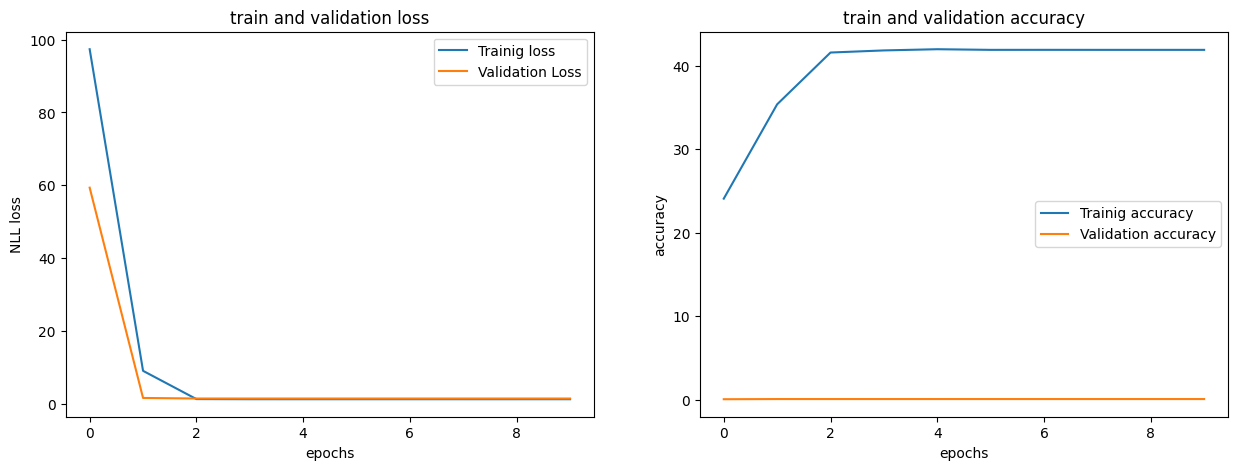

In [ ]:
#plots
plt.figure(figsize=(15, 5))
#plot losses

plt.subplot(1,2,1)
plt.plot(train_losses, label= "Trainig loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("NLL loss")
plt.title("train and validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label= "Trainig accuracy")
plt.plot(val_accuracies, label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("train and validation accuracy")
plt.legend()


Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction
```python
modele = torch.load(...)
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [ ]:
model_loaded = MyDumbModel()
model_loaded.load_state_dict(torch.load(ROOT_PATH+'dumb_model.pt'))
model_loaded.eval()

MyDumbModel(
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=6, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

## Entraînement de réseaux de neurones

### Modèles prenant en entrée les I/Q time series

#### Dataloaders

In [ ]:
#DataLoaders
b_size=64

train_dataset=MyDataset(TRAIN_PATH)
val_dataset=MyDataset(VAL_PATH)
test_dataset=MyDataset(TEST_PATH)

train_loader = DataLoader(train_dataset, batch_size=b_size,shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=b_size,shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=b_size,shuffle=True)

#### Modèle 1: CNN+LSTM
- Feature Extraction Layer : Conv1D + Pooling layers
- Linear Projection Layer : LSTM

In [ ]:
class Net_Conv_Lstm(nn.Module):
    def __init__(self):
        super(Net_Conv_Lstm, self).__init__()
        input_size =2
        num_filters=100
        kernel_size=3
        hidden_size=64
        num_layers=2
        num_classes=6

        self.cnn = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(64, 100, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(100, 100, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        cnn_out = self.cnn(x)
        lstm_out, _ = self.lstm(cnn_out.permute(0, 2, 1))
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        out = self.logsoftmax(out)
        return out


In [ ]:
torch.manual_seed(87)

using: cuda
Epoch 0, 	 Train Loss: 1.170, 	 Train Accuracy: 38.64%
Epoch 0, 	 Validation Loss: 0.909, 	 Validation Accuracy: 44.23%
Epoch 1, 	 Train Loss: 0.919, 	 Train Accuracy: 47.52%
Epoch 1, 	 Validation Loss: 0.700, 	 Validation Accuracy: 58.23%
Epoch 2, 	 Train Loss: 0.783, 	 Train Accuracy: 54.20%
Epoch 2, 	 Validation Loss: 0.811, 	 Validation Accuracy: 54.61%
Epoch 3, 	 Train Loss: 0.662, 	 Train Accuracy: 59.48%
Epoch 3, 	 Validation Loss: 0.607, 	 Validation Accuracy: 63.84%
Epoch 4, 	 Train Loss: 0.611, 	 Train Accuracy: 64.58%
Epoch 4, 	 Validation Loss: 0.763, 	 Validation Accuracy: 55.84%
Epoch 5, 	 Train Loss: 0.587, 	 Train Accuracy: 65.93%
Epoch 5, 	 Validation Loss: 0.547, 	 Validation Accuracy: 67.41%
Epoch 6, 	 Train Loss: 0.557, 	 Train Accuracy: 67.16%
Epoch 6, 	 Validation Loss: 0.547, 	 Validation Accuracy: 66.91%
Epoch 7, 	 Train Loss: 0.535, 	 Train Accuracy: 68.32%
Epoch 7, 	 Validation Loss: 0.556, 	 Validation Accuracy: 66.10%
Epoch 8, 	 Train Loss: 0.498

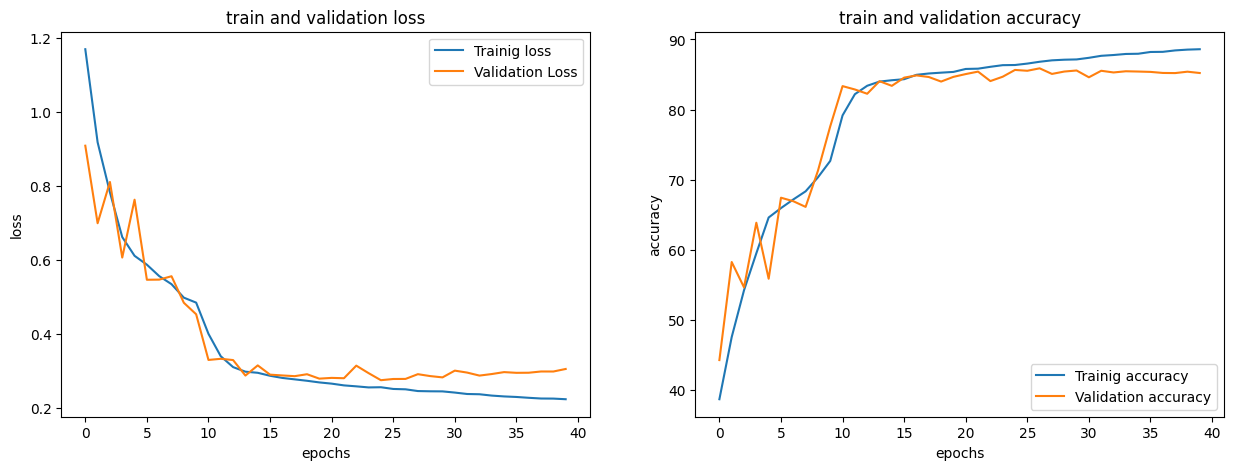

In [ ]:
device=("cuda" if torch.cuda.is_available() else "cpu")
print("using:", device)

model= Net_Conv_Lstm()
model.to(device)
model_name='CNN_LSTM'

loss= nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler= torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

nepochs= 40

train_losses=[]
train_accuracies=[]
val_losses=[]
val_accuracies=[]

best_loss=10e8
for epoch in range(nepochs):
  correct_train=0
  loss_train=0

  model.train()
  for idx, (sig, lab) in enumerate(train_loader):
    sig= sig.to(device)
    lab= lab.long().to(device)

    optimizer.zero_grad()

    predicted_b= model(sig)
    l= loss(predicted_b, lab)

    correct_train += predicted_b.argmax(dim=1).eq(lab.data).cpu().sum()
    loss_train += l.item()

    l.backward()
    optimizer.step()

  scheduler.step()
  acc_train= 100*correct_train/len(train_loader.dataset)
  loss_t= loss_train/ len(train_loader)
  train_losses.append(loss_t)
  train_accuracies.append(acc_train)
  print("Epoch {}, \t Train Loss: {:.3f}, \t Train Accuracy: {:.2f}%".format(epoch,loss_t, acc_train))

  model.eval()
  correct_val=0
  loss_val=0

  with torch.no_grad():
    for idx, (sig, lab) in enumerate(val_loader):
      sig= sig.to(device)
      lab= lab.long().to(device)

      predicted_v= model(sig)
      l_v= loss(predicted_v, lab)

      correct_val += predicted_v.argmax(dim=1).eq(lab.data).cpu().sum()
      loss_val += l_v.item()

  acc_val= 100*correct_val/len(val_loader.dataset)
  loss_v= loss_val/ len(val_loader)
  val_losses.append(loss_v)
  val_accuracies.append(acc_val)
  print("Epoch {}, \t Validation Loss: {:.3f}, \t Validation Accuracy: {:.2f}%".format(epoch,loss_v, acc_val))


#save model
torch.save(model.state_dict(), ROOT_PATH+f'{model_name}.pt')

#plots
plt.figure(figsize=(15, 5))
#plot losses

plt.subplot(1,2,1)
plt.plot(train_losses, label= "Trainig loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("train and validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label= "Trainig accuracy")
plt.plot(val_accuracies, label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("train and validation accuracy")
plt.legend()


#### Modèle 1 bis: Phase/Module +CNN+LSTM
- Feature Extraction Layer : Feature engineering (extract P and Q) + Conv1D + Pooling layers
- Linear Projection Layer : LSTM

In [ ]:
class Net_Conv_Lstm2(nn.Module):
    def __init__(self):
        super(Net_Conv_Lstm2, self).__init__()
        input_size =2
        num_filters=100
        kernel_size=3
        hidden_size=64
        num_layers=2
        num_classes=6



        self.cnn = nn.Sequential(
            nn.Conv1d(4, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(64, 100, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),

            nn.Conv1d(100, 100, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x= self.get_phase_norm(x)
        cnn_out = self.cnn(x)
        lstm_out, _ = self.lstm(cnn_out.permute(0, 2, 1))
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        out = self.logsoftmax(out)
        return out

    def get_phase_norm(self,signals):
      #signal (B, C, T)
      re=signals[:,0,:].unsqueeze(1)
      im=signals[:,1,:].unsqueeze(1)
      cplx=torch.complex(re,im)
      norm=cplx.abs()
      phase=cplx.angle()
      return torch.cat([re,im,norm,phase],dim=1)



In [ ]:
#On vérifie que le modèle fonctionne bien
for sig,lab in train_loader:
    print(f'input :{sig.shape}')
    model=Net_Conv_Lstm2()
    print(f'output :{(model(sig)).shape}')
    break


input :torch.Size([64, 2, 2048])
output :torch.Size([64, 6])


In [ ]:
torch.manual_seed(87)

using: cuda
Epoch 0, 	 Train Loss: 1.157, 	 Train Accuracy: 42.11%
Epoch 0, 	 Validation Loss: 1.020, 	 Validation Accuracy: 44.86%
Epoch 1, 	 Train Loss: 0.931, 	 Train Accuracy: 49.62%
Epoch 1, 	 Validation Loss: 0.979, 	 Validation Accuracy: 53.45%
Epoch 2, 	 Train Loss: 0.720, 	 Train Accuracy: 58.73%
Epoch 2, 	 Validation Loss: 0.616, 	 Validation Accuracy: 61.21%
Epoch 3, 	 Train Loss: 0.669, 	 Train Accuracy: 61.77%
Epoch 3, 	 Validation Loss: 0.611, 	 Validation Accuracy: 63.55%
Epoch 4, 	 Train Loss: 0.609, 	 Train Accuracy: 63.74%
Epoch 4, 	 Validation Loss: 0.556, 	 Validation Accuracy: 65.70%
Epoch 5, 	 Train Loss: 0.582, 	 Train Accuracy: 64.64%
Epoch 5, 	 Validation Loss: 0.538, 	 Validation Accuracy: 66.45%
Epoch 6, 	 Train Loss: 0.565, 	 Train Accuracy: 65.43%
Epoch 6, 	 Validation Loss: 0.533, 	 Validation Accuracy: 67.26%
Epoch 7, 	 Train Loss: 0.568, 	 Train Accuracy: 65.85%
Epoch 7, 	 Validation Loss: 0.523, 	 Validation Accuracy: 67.26%
Epoch 8, 	 Train Loss: 0.536

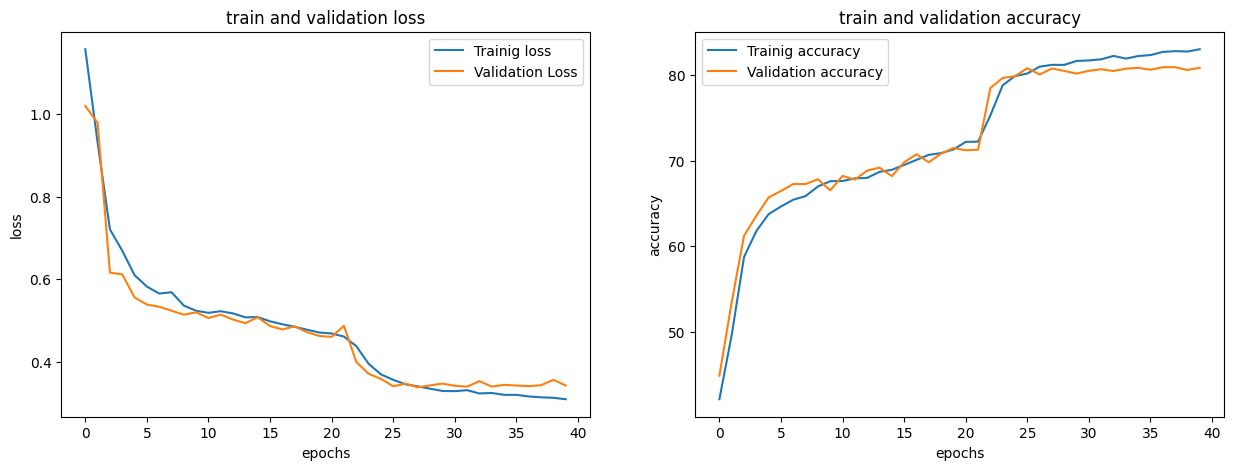

In [ ]:
device=("cuda" if torch.cuda.is_available() else "cpu")
print("using:", device)

model= Net_Conv_Lstm2()
model.to(device)
model_name='CNN_LSTM2'

loss= nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler= torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

nepochs= 40

train_losses=[]
train_accuracies=[]
val_losses=[]
val_accuracies=[]

best_loss=10e8
for epoch in range(nepochs):
  correct_train=0
  loss_train=0

  model.train()
  for idx, (sig, lab) in enumerate(train_loader):
    sig= sig.to(device)
    lab= lab.long().to(device)

    optimizer.zero_grad()

    predicted_b= model(sig)
    l= loss(predicted_b, lab)

    correct_train += predicted_b.argmax(dim=1).eq(lab.data).cpu().sum()
    loss_train += l.item()

    l.backward()
    optimizer.step()

  scheduler.step()
  acc_train= 100*correct_train/len(train_loader.dataset)
  loss_t= loss_train/ len(train_loader)
  train_losses.append(loss_t)
  train_accuracies.append(acc_train)
  print("Epoch {}, \t Train Loss: {:.3f}, \t Train Accuracy: {:.2f}%".format(epoch,loss_t, acc_train))

  model.eval()
  correct_val=0
  loss_val=0

  with torch.no_grad():
    for idx, (sig, lab) in enumerate(val_loader):
      sig= sig.to(device)
      lab= lab.long().to(device)

      predicted_v= model(sig)
      l_v= loss(predicted_v, lab)

      correct_val += predicted_v.argmax(dim=1).eq(lab.data).cpu().sum()
      loss_val += l_v.item()

  acc_val= 100*correct_val/len(val_loader.dataset)
  loss_v= loss_val/ len(val_loader)
  val_losses.append(loss_v)
  val_accuracies.append(acc_val)
  print("Epoch {}, \t Validation Loss: {:.3f}, \t Validation Accuracy: {:.2f}%".format(epoch,loss_v, acc_val))


#save model
torch.save(model.state_dict(), ROOT_PATH+f'{model_name}.pt')

#plots
plt.figure(figsize=(15, 5))
#plot losses

plt.subplot(1,2,1)
plt.plot(train_losses, label= "Trainig loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("train and validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label= "Trainig accuracy")
plt.plot(val_accuracies, label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("train and validation accuracy")
plt.legend()


#### Modèle 2 : Vision Transformer
- Transformer


In [ ]:
def signal_to_patch(x, patch_size):
    """
    Args:
        x: Tensor representing the image of shape [B, C, T]
        patch_size: Number of pixels per dimension of the patches (integer)
        flatten_channels: If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, C, T = x.shape
    x = x.reshape(B, C, T//patch_size, patch_size) #(B, C, T', patch_size)
    x = x.permute(0, 2, 1, 3)
    #flatten_channels:
    x = x.flatten(2, 3)  # [B, T', C*patch_size]
    return x

torch.Size([1, 64, 64])

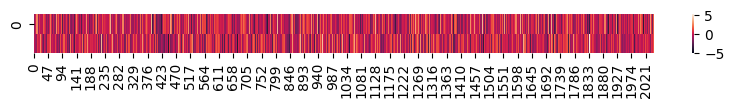

In [ ]:
import seaborn as sns
signal_example=train_signals[0]
plt.figure(figsize=(10,0.5))
sns.heatmap(signal_example.transpose())
signal=torch.from_numpy(signal_example).unsqueeze(0).permute(0,2,1)
signal_to_patch(signal, 32).shape

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """Attention Block.

        Args:
            embed_dim: Dimensionality of input and attention feature vectors
            hidden_dim: Dimensionality of hidden layer in feed-forward network
                         (usually 2-4x larger than embed_dim)
            num_heads: Number of heads to use in the Multi-Head Attention block
            dropout: Amount of dropout to apply in the feed-forward network
        """
        super().__init__()

        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.linear = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        inp_x = self.layer_norm_1(x)
        x = x + self.attn(inp_x, inp_x, inp_x)[0]
        x = x + self.linear(self.layer_norm_2(x))
        return x

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        hidden_dim,
        num_channels,
        num_heads,
        num_layers,
        num_classes,
        patch_size,
        num_patches,
        dropout=0.0,
    ):
        """Vision Transformer.

        Args:
            embed_dim: Dimensionality of the input feature vectors to the Transformer
            hidden_dim: Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels: Number of channels of the input (3 for RGB)
            num_heads: Number of heads to use in the Multi-Head Attention block
            num_layers: Number of layers to use in the Transformer
            num_classes: Number of classes to predict
            patch_size: Number of pixels that the patches have per dimension
            num_patches: Maximum number of patches an image can have
            dropout: Amount of dropout to apply in the feed-forward network and
                      on the input encoding
        """
        super().__init__()

        self.patch_size = patch_size

        # Layers/Networks
        self.input_layer = nn.Linear(num_channels * (patch_size), embed_dim)
        self.transformer = nn.Sequential(
            *(AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers))
        )
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_dim), nn.Linear(embed_dim, num_classes))
        self.log_softmax = nn.LogSoftmax()
        self.dropout = nn.Dropout(dropout)

        # Parameters/Embeddings
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, 1 + num_patches, embed_dim))

    def forward(self, x):
        # Preprocess input
        # print(x.shape)
        x = signal_to_patch(x, self.patch_size)
        # print(x.shape)
        B, T, _ = x.shape
        x = self.input_layer(x)
        # print(x.shape)

        # Add CLS token and positional encoding
        cls_token = self.cls_token.repeat(B, 1, 1)
        # print(cls_token.shape)
        x = torch.cat([cls_token, x], dim=1)
        # print(x.shape)
        x = x + self.pos_embedding[:, : T + 1]
        # print(self.pos_embedding[:, : T + 1].shape)
        # print(x.shape)

        # Apply Transforrmer
        x = self.dropout(x)
        x = x.transpose(0, 1)
        # print(x.shape)
        x = self.transformer(x)
        # print(x.shape)

        # Perform classification prediction
        cls = x[0]
        out = self.mlp_head(cls)
        out= self.log_softmax(out)

        return out

In [ ]:
#On vérifie que le modèle fonctionne bien
for sig,lab in train_loader:
    print(f'input :{sig.shape}')
    model=VisionTransformer(
        embed_dim=256,
        hidden_dim=256,
        num_channels=2,
        num_heads=4,
        num_layers=4,
        num_classes=6,
        patch_size=32,
        num_patches=64,
        dropout=0.0
    )
    print(f'output :{(model(sig)).shape}')
    break

input :torch.Size([64, 2, 2048])
output :torch.Size([64, 6])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


using: cuda
Epoch 0, 	 Train Loss: 1.827, 	 Train Accuracy: 17.83%
Epoch 0, 	 Validation Loss: 1.736, 	 Validation Accuracy: 21.08%
Epoch 1, 	 Train Loss: 1.707, 	 Train Accuracy: 21.78%
Epoch 1, 	 Validation Loss: 1.615, 	 Validation Accuracy: 24.97%
Epoch 2, 	 Train Loss: 1.658, 	 Train Accuracy: 23.91%
Epoch 2, 	 Validation Loss: 1.637, 	 Validation Accuracy: 25.59%
Epoch 3, 	 Train Loss: 1.671, 	 Train Accuracy: 23.84%
Epoch 3, 	 Validation Loss: 1.690, 	 Validation Accuracy: 23.69%
Epoch 4, 	 Train Loss: 1.670, 	 Train Accuracy: 23.65%
Epoch 4, 	 Validation Loss: 1.613, 	 Validation Accuracy: 25.68%
Epoch 5, 	 Train Loss: 1.667, 	 Train Accuracy: 23.87%
Epoch 5, 	 Validation Loss: 1.741, 	 Validation Accuracy: 20.02%
Epoch 6, 	 Train Loss: 1.709, 	 Train Accuracy: 22.47%
Epoch 6, 	 Validation Loss: 1.677, 	 Validation Accuracy: 23.65%
Epoch 7, 	 Train Loss: 1.642, 	 Train Accuracy: 24.75%
Epoch 7, 	 Validation Loss: 1.653, 	 Validation Accuracy: 24.19%
Epoch 8, 	 Train Loss: 1.616

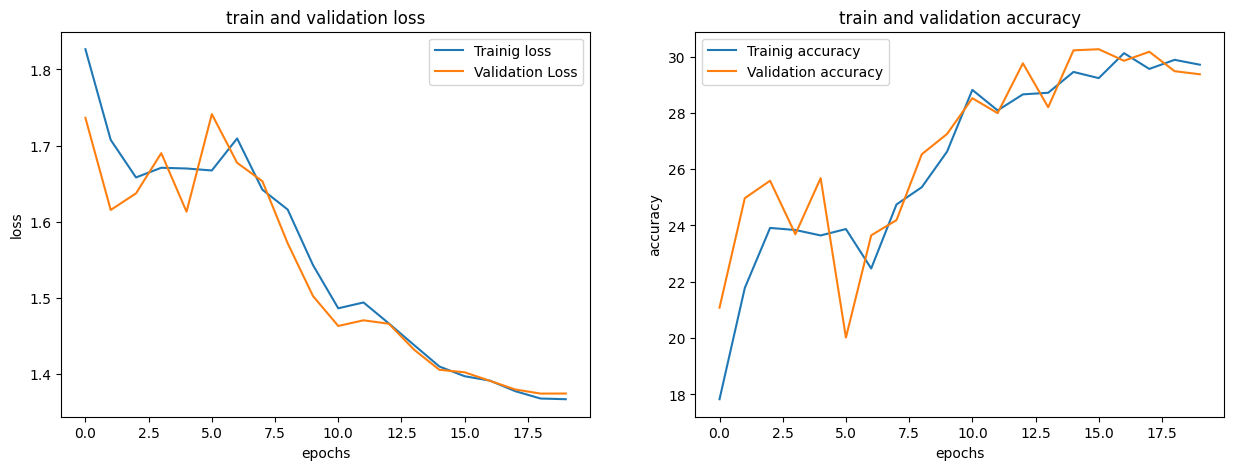

In [ ]:
device=("cuda" if torch.cuda.is_available() else "cpu")
print("using:", device)

model= VisionTransformer(
        embed_dim=256,
        hidden_dim=512,
        num_channels=2,
        num_heads=4,
        num_layers=4,
        num_classes=6,
        patch_size=32,
        num_patches=64,
        dropout=0.0)
model.to(device)
model_name='Vision_Transformer'

loss= nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler= torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

nepochs= 20

train_losses=[]
train_accuracies=[]
val_losses=[]
val_accuracies=[]

best_loss=10e8
for epoch in range(nepochs):
  correct_train=0
  loss_train=0

  model.train()
  for idx, (sig, lab) in enumerate(train_loader):
    sig= sig.to(device)
    lab= lab.long().to(device)

    optimizer.zero_grad()

    predicted_b= model(sig)
    l= loss(predicted_b, lab)

    correct_train += predicted_b.argmax(dim=1).eq(lab.data).cpu().sum()
    loss_train += l.item()

    l.backward()
    optimizer.step()

  scheduler.step()
  acc_train= 100*correct_train/len(train_loader.dataset)
  loss_t= loss_train/ len(train_loader)
  train_losses.append(loss_t)
  train_accuracies.append(acc_train)
  print("Epoch {}, \t Train Loss: {:.3f}, \t Train Accuracy: {:.2f}%".format(epoch,loss_t, acc_train))

  model.eval()
  correct_val=0
  loss_val=0

  with torch.no_grad():
    for idx, (sig, lab) in enumerate(val_loader):
      sig= sig.to(device)
      lab= lab.long().to(device)

      predicted_v= model(sig)
      l_v= loss(predicted_v, lab)

      correct_val += predicted_v.argmax(dim=1).eq(lab.data).cpu().sum()
      loss_val += l_v.item()

  acc_val= 100*correct_val/len(val_loader.dataset)
  loss_v= loss_val/ len(val_loader)
  val_losses.append(loss_v)
  val_accuracies.append(acc_val)
  print("Epoch {}, \t Validation Loss: {:.3f}, \t Validation Accuracy: {:.2f}%".format(epoch,loss_v, acc_val))


#save model
torch.save(model.state_dict(), ROOT_PATH+f'{model_name}.pt')

#plots
plt.figure(figsize=(15, 5))
#plot losses

plt.subplot(1,2,1)
plt.plot(train_losses, label= "Trainig loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("train and validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label= "Trainig accuracy")
plt.plot(val_accuracies, label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("train and validation accuracy")
plt.legend()


### Modèles prenant en entrée les diagrammes de constellation

#### DataLoaders

In [ ]:
TRAIN_IMG_PATH=ROOT_PATH+'train_constellations.hdf5'
VAL_IMG_PATH=ROOT_PATH+'val_constellations.hdf5'
TEST_IMG_PATH=ROOT_PATH+'test_constellations.hdf5'

(30000, 48, 48, 3)

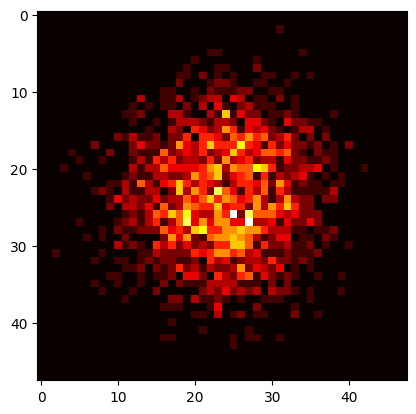

In [ ]:
train_img = h5py.File(TRAIN_IMG_PATH , 'r')

train_img_signals = np.array(train_img['img_signals'])
train_img_snr =  np.array(train_img['snr'])
train_img_labels_id = np.array(train_img['labels'])

train_img.close()
plt.imshow(train_img_signals[300])
train_img_signals.shape

In [ ]:
del train_img_signals

In [ ]:
class MyDatasetImg(torch.utils.data.Dataset):
  def __init__(self, path_to_data):
    self.path= path_to_data
    self.data=None

  def __getitem__(self, i):
    if self.data==None:
      self.data= h5py.File(self.path, 'r')
    signal= torch.from_numpy(np.array(self.data["img_signals"][i]))
    label= torch.from_numpy(np.array(self.data["labels"][i]))
    return (signal, label)

  def __len__(self):
    with h5py.File(self.path, 'r') as f:
      return np.array(f["img_signals"]).shape[0]

  def close(self):
      if self.data is not None:
        self.data.close()
        self.data= None

In [ ]:
#DataLoaders
from torch.utils.data import DataLoader
b_size=64

train_dataset_img=MyDatasetImg(TRAIN_IMG_PATH)
val_dataset_img=MyDatasetImg(VAL_IMG_PATH)
test_dataset_img=MyDatasetImg(TEST_IMG_PATH)

train_loader_img = DataLoader(train_dataset_img, batch_size=b_size,shuffle=True, num_workers=2, pin_memory=True)
val_loader_img = DataLoader(val_dataset_img, batch_size=b_size,shuffle=False, num_workers=2, pin_memory=True)
test_loader_img = DataLoader(test_dataset_img, batch_size=b_size,shuffle=True)

#### Modèle 3 : CNN 2D

In [ ]:
import torch
import torch.nn as nn

class ConstellationNet(nn.Module):
    def __init__(self, X1, X2, X3, num_classes=6):
        super(ConstellationNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 128, kernel_size=(5, 5), padding='valid')
        self.prelu1 = nn.PReLU(init=0.25)
        self.pool1 = nn.AvgPool2d(kernel_size=(2, 2), stride=2)

        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding='same')
        self.prelu2 = nn.PReLU(init=0.25)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding='same')
        self.prelu3 = nn.PReLU(init=0.25)
        self.pool2 = nn.AvgPool2d(kernel_size=(2, 2), stride=2)

        self.conv4 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding='same')
        self.prelu4 = nn.PReLU(init=0.25)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding='same')
        self.prelu5 = nn.PReLU(init=0.25)
        self.pool3 = nn.AvgPool2d(kernel_size=(2, 2), stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(32 * ((X1-4)//8) **2, 1024)
        self.prelu6 = nn.PReLU(init=0.25)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(1024, 512)
        self.prelu7 = nn.PReLU(init=0.25)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(512, num_classes)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x=x.permute(0,3,1,2).float()
        x = self.conv1(x)
        x = self.prelu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.conv3(x)
        x = self.prelu3(x)
        x = self.pool2(x)

        x = self.conv4(x)
        x = self.prelu4(x)
        x = self.conv5(x)
        x = self.prelu5(x)
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.prelu6(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.prelu7(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.logsoftmax(x)

        return x

# Define the dimensions
X1, X2, X3 = 48, 48, 3

# Instantiate the model
model = ConstellationNet(X1, X2, X3)


In [ ]:
#On vérifie que le modèle fonctionne bien
for sig,lab in train_loader_img:
    print(f'input :{sig.shape}')
    model=ConstellationNet(X1,X2,X3)
    print(f'output :{(model(sig)).shape}')
    break

input :torch.Size([64, 48, 48, 3])
output :torch.Size([64, 6])


In [ ]:
del train_signals
del val_signals
del test_signals
del test_snr
del test_labels_id
del constel_test
del constel_test_file
del constel_train
del constel_train_file
del constel_val
del constel_val_file

In [ ]:
del train_labels_id
del train_snr
del train_dataset_img


In [ ]:
device=("cuda" if torch.cuda.is_available() else "cpu")
print("using:", device)

model= ConstellationNet(X1,X2,X3)
model.to(device)
model_name='ConstellationsNet'

loss= nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler= torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

nepochs= 40

train_losses=[]
train_accuracies=[]
val_losses=[]
val_accuracies=[]

best_loss=10e8
for epoch in range(nepochs):
  correct_train=0
  loss_train=0

  model.train()
  for idx, (sig, lab) in enumerate(train_loader_img):
    sig= sig.to(device)
    lab= lab.long().to(device)

    optimizer.zero_grad()

    predicted_b= model(sig)
    l= loss(predicted_b, lab)

    correct_train += predicted_b.argmax(dim=1).eq(lab.data).cpu().sum()
    loss_train += l.item()

    l.backward()
    optimizer.step()

  scheduler.step()
  acc_train= 100*correct_train/len(train_loader_img.dataset)
  loss_t= loss_train/ len(train_loader_img)
  train_losses.append(loss_t)
  train_accuracies.append(acc_train)
  print("Epoch {}, \t Train Loss: {:.3f}, \t Train Accuracy: {:.2f}%".format(epoch,loss_t, acc_train))

  model.eval()
  correct_val=0
  loss_val=0

  with torch.no_grad():
    for idx, (sig, lab) in enumerate(val_loader_img):
      sig= sig.to(device)
      lab= lab.long().to(device)

      predicted_v= model(sig)
      l_v= loss(predicted_v, lab)

      correct_val += predicted_v.argmax(dim=1).eq(lab.data).cpu().sum()
      loss_val += l_v.item()

  acc_val= 100*correct_val/len(val_loader_img.dataset)
  loss_v= loss_val/ len(val_loader_img)
  val_losses.append(loss_v)
  val_accuracies.append(acc_val)
  print("Epoch {}, \t Validation Loss: {:.3f}, \t Validation Accuracy: {:.2f}%".format(epoch,loss_v, acc_val))


#save model
torch.save(model.state_dict(), ROOT_PATH+f'{model_name}.pt')

#plots
plt.figure(figsize=(15, 5))
#plot losses

plt.subplot(1,2,1)
plt.plot(train_losses, label= "Trainig loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("train and validation loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label= "Trainig accuracy")
plt.plot(val_accuracies, label="Validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("train and validation accuracy")
plt.legend()


Epoch 19, 	 Train Loss: 0.480, 	 Train Accuracy: 71.70%
Epoch 19, 	 Validation Loss: 0.467, 	 Validation Accuracy: 71.90%
Epoch 20, 	 Train Loss: 0.475, 	 Train Accuracy: 71.87%
Epoch 20, 	 Validation Loss: 0.463, 	 Validation Accuracy: 72.83%
Epoch 21, 	 Train Loss: 0.470, 	 Train Accuracy: 72.08%
Epoch 21, 	 Validation Loss: 0.473, 	 Validation Accuracy: 72.23%
Epoch 22, 	 Train Loss: 0.469, 	 Train Accuracy: 72.46%
Epoch 22, 	 Validation Loss: 0.470, 	 Validation Accuracy: 72.76%
Epoch 23, 	 Train Loss: 0.466, 	 Train Accuracy: 72.37%
Epoch 23, 	 Validation Loss: 0.469, 	 Validation Accuracy: 71.54%
Epoch 24, 	 Train Loss: 0.460, 	 Train Accuracy: 72.56%
Epoch 24, 	 Validation Loss: 0.488, 	 Validation Accuracy: 73.06%
Epoch 25, 	 Train Loss: 0.461, 	 Train Accuracy: 72.91%
Epoch 25, 	 Validation Loss: 0.466, 	 Validation Accuracy: 73.17%
Epoch 26, 	 Train Loss: 0.457, 	 Train Accuracy: 72.76%
Epoch 26, 	 Validation Loss: 0.467, 	 Validation Accuracy: 72.95%
Epoch 27, 	 Train Loss: 

KeyboardInterrupt: ignored

using: cuda


In [ ]:
#save model
torch.save(model.state_dict(), ROOT_PATH+f'{model_name}.pt')

## Synthèse de résultats

Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test

#### Test selon SNR

In [ ]:
#Test
test = h5py.File(TEST_PATH , 'r')

test_signals = np.array(test['signaux'])
test_snr =  np.array(test['snr'])
test_labels_id = np.array(test['labels'])

test.close()

1. On charge les modèles sauvegardés

In [ ]:
device=("cuda" if torch.cuda.is_available() else "cpu")
print("using:", device)

using: cuda


In [ ]:
model_cnn_lstm = Net_Conv_Lstm()
model_cnn_lstm.load_state_dict(torch.load(ROOT_PATH+'CNN_LSTM.pt',map_location=device))
model_cnn_lstm.eval()

Net_Conv_Lstm(
  (cnn): Sequential(
    (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (8): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (9): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=

In [ ]:
model_cnn_lstm.to(device)

Net_Conv_Lstm(
  (cnn): Sequential(
    (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (8): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (9): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=

In [ ]:
model_cnn_lstm2 = Net_Conv_Lstm2()
model_cnn_lstm2.load_state_dict(torch.load(ROOT_PATH+'CNN_LSTM2.pt',map_location=device))
model_cnn_lstm2.eval()

Net_Conv_Lstm2(
  (cnn): Sequential(
    (0): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (8): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (9): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias

In [ ]:
model_cnn_lstm2.to(device)

Net_Conv_Lstm2(
  (cnn): Sequential(
    (0): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (8): Conv1d(100, 100, kernel_size=(5,), stride=(1,), padding=(2,))
    (9): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias

In [ ]:
def group_signals_bysnr(signals, labels, snr):
    grouped_signals={}
    # Iterate over each signal and its corresponding attribute (label or snr)
    for signal, label, snr in zip(signals, labels, snr):
        if snr not in grouped_signals.keys():
            signal=torch.from_numpy(np.array(signal)).permute((1,0)) #(T,C) --> (C,T)
            grouped_signals[snr]=[(signal, label)]
        else:
            signal=torch.from_numpy(np.array(signal)).permute((1,0))
            grouped_signals[snr].append((signal,label))
    return grouped_signals

In [ ]:
len(list(zip(test_signals, test_labels_id, test_snr)))

10000

In [ ]:
test_data_bysnr = group_signals_bysnr(test_signals, test_labels_id, test_snr)

In [ ]:
# test_snr[snr] is a list of tuples where each tuple contains a signal and its label : [(signal1, label1), (signal2, label2), ...]

def get_accuracy_snr(model, data_bysnr):
    model.eval()
    correct_test = 0
    loss_test = 0
    loss= nn.NLLLoss()

    with torch.no_grad():
        for idx, (sig, lab) in enumerate(data_bysnr):
            sig = torch.tensor(sig).to(device)
            lab = torch.tensor([lab]).long().to(device)  # Assuming lab is a scalar, convert it to a tensor

            predicted_test = model(sig.unsqueeze(0))  # Add a batch dimension
            l_test = loss(predicted_test, lab)

            correct_test += predicted_test.argmax(dim=1).eq(lab.data).cpu().sum()
            loss_test += l_test.item()

    acc_test = 100 * correct_test / len(data_bysnr)
    loss_test = loss_test / len(data_bysnr)

    return acc_test


In [ ]:
test_accuracies_snr={}
for model in [model_cnn_lstm, model_cnn_lstm2]:
  test_accuracies_snr[model]={}
  for snr in test_data_bysnr.keys():
    test_accuracies_snr[model][snr]=get_accuracy_snr(model, test_data_bysnr[snr])

<ipython-input-36-31c00537767f>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sig = torch.tensor(sig).to(device)


In [ ]:
test_accuracies_snr[model_cnn_lstm2]

{30: tensor(99.9624),
 20: tensor(99.8707),
 0: tensor(41.7355),
 10: tensor(82.9231)}

In [ ]:
models={model_cnn_lstm : 'cnn_lstm', model_cnn_lstm2 :'cnn_lstm_angle_phase'}

Text(0, 0.5, 'Test accuracy')

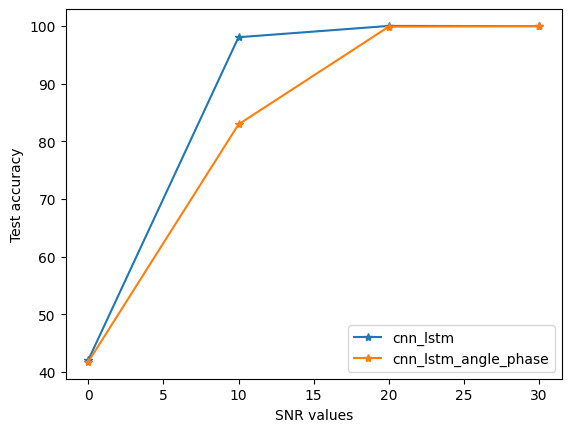

In [ ]:
plt.figure()
for model in models.keys():
  y=sorted(test_accuracies_snr[model].items(),key= lambda x : x[0])
  x=list(zip(*y))[0]
  y=list(zip(*y))[1]
  plt.plot(x,y,'-*',label=models[model])
plt.xlabel('SNR values')
plt.legend()
plt.ylabel('Test accuracy')